In [11]:
import requests, re, unidecode
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
import numpy as np
from bs4 import BeautifulSoup, NavigableString
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split


# FA CLASSES

In [301]:
free_agents_url = "https://www.spotrac.com/nba/free-agents/"
years = range(2020,2023)

data = []
#gathering the FA data for 2020-2022
for y in years:
    
    #retrieving the HTML for the years free agents
    top_html = requests.get(free_agents_url + str(y))
    soup = BeautifulSoup(top_html.text, 'html.parser')
    table = soup.find_all('table')[0]
    
    #looping through each player in the HTML
    for row in table.find('tbody').find_all('tr'):

        tds = row.find_all('td') 
        player = unidecode.unidecode(tds[0].text).replace(".","").strip()
        pid = tds[0].find_all('a', href=True)[0]['href'].split("/")[5]
        pos = tds[1].text.strip()
        age =  tds[2].text.strip().replace('>','')
        typ = tds[3].text.strip()
        teamFrom = tds[4].text.strip()
        teamTo = tds[5].text.strip()
        yrs = tds[6].text.strip()
        total = tds[7].text.strip().replace("$", "").replace(",", "")
        avg = tds[8].text.strip().replace("$", "").replace(",", "")
                    
        data.append([y, player, pid, teamFrom, teamTo, pos, age, np.nan, typ, np.nan, np.nan, yrs, total, avg])
        
### data cleaning and formatting              
cols = ['year', 'player', 'id', 'teamFrom', 'teamTo', 'pos', 'age', 'exp', 'type', 'rights', 'lastAav', 'yrs', 'total', 'avg']
fa_master_df = pd.DataFrame(data, columns=cols)       
fa_master_df = fa_master_df[fa_master_df['player'] != 'Totals']
fa_master_df.replace("", np.nan, inplace=True)
fa_master_df.replace("-0", np.nan, inplace=True)
fa_master_df.replace("0-", np.nan, inplace=True)
fa_master_df.replace("-", np.nan, inplace=True)
fa_master_df['total'] = pd.to_numeric(fa_master_df['total'])

#changing names to match basketball reference
fa_master_df['player'] = fa_master_df['player'].replace('Joshia Gray', 'Josh Gray')
fa_master_df['player'] = fa_master_df['player'].replace('Jose Barea', 'JJ Barea')
fa_master_df['player'] = fa_master_df['player'].replace('Ishmael Smith', 'Ish Smith')
fa_master_df['player'] = fa_master_df['player'].replace('Louis Williams', 'Lou Williams')
fa_master_df['player'] = fa_master_df['player'].replace('Sviatoslav Mykhailiuk', 'Svi Mykhailiuk')
fa_master_df['player'] = fa_master_df['player'].replace('Danuel House', 'Danuel House Jr')
fa_master_df['player'] = fa_master_df['player'].replace('Nicolas Claxton', 'Nic Claxton')
fa_master_df['player'] = fa_master_df['player'].replace('Mohamed Bamba', 'Mo Bamba')

# saving the cleaned data - Using excel to avoid encoding issues on foreign names
fa_master_df.to_excel("2020to2022FreeAgents.xlsx", index=False)

# SALARY CAP 

In [303]:
# retrieving salary cap data 
gm_url = "https://basketball.realgm.com/nba/info/salary_cap"
top_html = requests.get(gm_url)
soup = BeautifulSoup(top_html.text, 'html.parser')
tables = soup.find_all('table', attrs={'class':'basketball compact'})
cap = tables[0].find("tbody").find_all("tr")
max_contract = tables[1].find("tbody").find_all("tr")

# cap data for each season
cap_data = []
for tr in cap:
    season = int(tr.find("td", attrs={"data-th":"Season"})['rel']) - 1
    cap = tr.find("td", attrs={"data-th":"Salary Cap"})['rel']
    tax = tr.find("td", attrs={"data-th":"Luxury Tax"})['rel']
    bae = tr.find("td", attrs={"data-th":"BAE"})['rel']
    mle_nontax = tr.find("td", attrs={"data-th":"Non-Taxpayer"})['rel']
    mle_tax = tr.find("td", attrs={"data-th":"Taxpayer"})['rel']
    mle_team = tr.find("td", attrs={"data-th":"Team Room"})['rel']

    cap_data.append([season, cap, tax, bae, mle_nontax, mle_tax, mle_team])

cap_cols = ['season', 'cap', 'luxury_tax', 'bae', 'midlevel_exp_nontax', 'midlevel_exp_tax', 'midlevel_exp_teamroom']
cap_df = pd.DataFrame(cap_data, columns=cap_cols)
cap_contract_data = cap_df.replace("-", 0).replace('99999999',0)

#forcing numeric dtype
cap_contract_data['cap'] = pd.to_numeric(cap_contract_data['cap'])
cap_contract_data['luxury_tax'] = pd.to_numeric(cap_contract_data['luxury_tax'])
cap_contract_data['bae'] = pd.to_numeric(cap_contract_data['bae'])
cap_contract_data['midlevel_exp_nontax'] = pd.to_numeric(cap_contract_data['midlevel_exp_nontax'])
cap_contract_data['midlevel_exp_tax'] = pd.to_numeric(cap_contract_data['midlevel_exp_tax'])
cap_contract_data['midlevel_exp_teamroom'] = pd.to_numeric(cap_contract_data['midlevel_exp_teamroom'])

#replacing 0s back to nans since the coversions to numeric are complete
cap_contract_data = cap_contract_data.replace(0, np.nan)

#export
cap_contract_data.to_excel("cap_contract_data.xlsx", index=False)

# PLAYER SEASON STATS PER GAME

In [304]:
# grabbing player averages for seasons 2019-2022
years = ['2019', '2020', '2021', '2022']
df_pg = pd.DataFrame()

for y in years:
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(y)

    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')

    table=soup.find_all(class_="full_table")

    """ Extracting List of column names"""
    head=soup.find(class_="thead")
    column_names_raw=[head.text for item in head][0]
    column_names_polished=column_names_raw.replace("\n",",").split(",")[2:-1]


    """Extracting full list of player_data"""
    players=[]

    for i in range(len(table)):

        player_=[]

        for td in table[i].find_all("td"):
            d = td.text
            if d =="":
                player_.append(np.nan)
            else:
                player_.append(d)

        players.append(player_)

    temp = 'df_{}'.format(y)
    temp=pd.DataFrame(players, columns=column_names_polished)

    #cleaning the player's name from occasional special characters
    temp['Player']=temp['Player'].str.replace(r'*', '', regex=True)
    temp['Player']=temp['Player'].str.replace('.', '', regex=False )
    
    # removing accents from names
    temp['Player'] = temp['Player'].apply(unidecode.unidecode)
    
    # adding the season year
    temp['season'] = int(y)
    
    df_pg = pd.concat([df_pg, temp], ignore_index=True)
    
df_pg.to_csv("2019_2021_player_pg_stats.csv", index = False)

# AWARDS

In [305]:
# grabbing historical award season award data
awards = ['all_league', 'mvp', 'dpoy', 'smoy', 'mip']
awards_url = "https://www.basketball-reference.com/awards/{}.html"

awards_data = []
for a in awards:
    
    r = requests.get(awards_url.format(a))
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')
    table = soup.find_all("table")[0].find("tbody")
    
    if a == 'all_league':
        #all-nba teams
        for tr in table:
            data = []
            if isinstance(tr, NavigableString):
                pass
            else:
                try:
                    season = int(tr.find_all("th", attrs={'data-stat':'season'})[0].text[0:4]) + 1

                    items = tr.find_all('td')

                    league = items[0].text

                    if league == 'ABA':
                        pass
                    else:
                        all_team = items[1].text
                        c = unidecode.unidecode(items[3].find('a').text)
                        f1 = unidecode.unidecode(items[4].find('a').text)
                        f2 = unidecode.unidecode(items[5].find('a').text)
                        g1 = unidecode.unidecode(items[6].find('a').text)
                        g2 = unidecode.unidecode(items[7].find('a').text)

                        team = [c, f1, f2, g1, g2]

                        for p in team:
                            awards_data.append([season, all_team, p])

                except:
                    pass
    
    # MVP, DPOY, MIP, SMOY are all formatted the same
    else:
        for tr in table:
            data = []
            if isinstance(tr, NavigableString):
                pass
            else:
                season = int(tr.find_all("th", attrs={'data-stat':'season'})[0].text[0:4]) + 1
                items = tr.find_all('td')
                player = unidecode.unidecode(items[1].text)
                awards_data.append([season, a.upper(), player])   
    
awards_df = pd.DataFrame(awards_data, columns=['season', 'award', 'player'])  

# player name formatting
awards_df['player'] = awards_df['player'].str.replace(r'*', '', regex=True).str.replace('.', '', regex=False)

#export
awards_df.to_excel("nba_season_player_awards.xlsx", index=False)

# MERGING PLAYER SEASON STATS WITH AWARDS

In [306]:
awards_df = awards_df[(awards_df['season'] >= 2016)]
awarded_players = awards_df['player'].unique()
# these are the data point that will be created from the award data
# previous season awards and the counts over the last 3 seasons for the same awards
df_pg[['mvpLastSeason','mvpLast3Seasons',
           'allNba1LastSeason', 'allNba1Last3Season',
           'allNba2LastSeason', 'allNba2Last3Season',
           'allNba3LastSeason', 'allNba3Last3Season',
           'dpoyLastSeason', 'dpoyLast3Season',
           'smoyLastSeason', 'smoyLast3Season',
           'mipLastSeason', 'mipLast3Season',
          ]] = 0

# looping through the list of players who have one an award
for ap in awarded_players:    
    # looping through the years of data that will be used in the model
    for y in [2020, 2021, 2022]:
        
        # saving the player's index from the master dataframe so that the award 
        # info can be added back to it after it is calculated
        idx = df_pg[(df_pg['Player'] == ap) & (df_pg['season'] == y)].index
                
        mvpLastSeason = 0
        allNba1LastSeason = 0
        allNba2LastSeason = 0
        allNba3LastSeason = 0
        dpoyLastSeason = 0
        smoyLastSeason = 0
        mipLastSeason = 0
        
        mvpLast3Season = 0
        allNba1Last3Season = 0
        allNba2Last3Season = 0
        allNba3Last3Season = 0
        dpoyLast3Season = 0
        smoyLast3Season = 0
        mipLast3Season = 0
        
        # this loop will lookback to the prior 3 seasons and sum up the number of awards for each player
        for py in range(y - 3, y):
            # creates a temp. df for the current looped player and the season of interest
            single_season_awards = awards_df[(awards_df['season'] == py) & (awards_df['player'] == ap)]
            
            # loops through all the awards for the player in the single season
            for award in single_season_awards.itertuples():
                # grabbing the name of the award
                awarded = award[2]
                
                #building the award count for the 3 previous seasons
                if awarded == '1st':
                    allNba1Last3Season += 1

                elif awarded == '2nd':
                    allNba2Last3Season += 1

                elif awarded == '3rd':
                    allNba3Last3Season += 1

                elif awarded == 'MVP':
                    mvpLast3Season += 1

                elif awarded == 'DPOY':
                    dpoyLast3Season += 1

                elif awarded == 'SMOY':
                    smoyLast3Season += 1

                elif awarded == 'MIP':
                    mipLast3Season += 1
                 
                # adding the count if the player won the award in the previous season
                if py == (y - 1):
                    if awarded == 'MVP':
                        mvpLastSeason += 1

                    elif awarded == '1st':
                        allNba1LastSeason += 1

                    elif awarded == '2nd':
                        allNba2LastSeason += 1

                    elif awarded == '3rd':
                        allNba3LastSeason += 1

                    elif awarded == 'DPOY': 
                        dpoyLastSeason += 1

                    elif awarded == 'SMOY':
                        smoyLastSeason += 1

                    elif awarded == 'MIP':
                        mipLastSeason += 1
        
        # adding the players award info for a single season using the index saved at the beginning of the out loop
        df_pg.loc[idx,'mvpLastSeason'] = mvpLastSeason
        df_pg.loc[idx,'mvpLast3Seasons']= mvpLast3Season
        df_pg.loc[idx,'allNba1LastSeason']= allNba1LastSeason
        df_pg.loc[idx,'allNba1Last3Season']= allNba1Last3Season
        df_pg.loc[idx,'allNba2LastSeason']= allNba2LastSeason
        df_pg.loc[idx,'allNba2Last3Season']= allNba2Last3Season
        df_pg.loc[idx,'allNba3LastSeason']= allNba3LastSeason
        df_pg.loc[idx,'allNba3Last3Season']= allNba3Last3Season
        df_pg.loc[idx,'dpoyLastSeason']= dpoyLastSeason
        df_pg.loc[idx,'dpoyLast3Season']= dpoyLast3Season
        df_pg.loc[idx,'smoyLastSeason']= smoyLastSeason
        df_pg.loc[idx,'smoyLast3Season']= smoyLast3Season
        df_pg.loc[idx,'mipLastSeason']= mipLastSeason
        df_pg.loc[idx,'mipLast3Season']= mipLast3Season
        
df_pg.to_excel("2019_2022_player_pgAvg_w_awards.xlsx", index = False)

# ADDING IF A PLAYER IS A FA AT THE END OF THE YEAR

In [308]:
# adding columns to the master df which will be updated below
df_pg['faSeason'] = 0
df_pg['faType'] = np.nan
df_pg['contractAmt'] = np.nan
df_pg['contractTerm'] = np.nan

# adding the cap data gathered above into the master data frame
cap2020 = float(cap_contract_data[(cap_contract_data['season'] == 2020)]['cap'].values[0])
cap2021 = float(cap_contract_data[(cap_contract_data['season'] == 2021)]['cap'].values[0])
cap2022 = float(cap_contract_data[(cap_contract_data['season'] == 2022)]['cap'].values[0])

suffixes = ['Jr', 'Sr', 'II', 'III', 'IV']
no_match = []
for y in [2020, 2021, 2022]:
    # the year has to be conditioned for in regards to the filters used when assigning the 'free_agents' variable
    # 2020-2021 is filtered for only players who received contracts so the model can be trained on contract data
    # 2022 doesn't need the contract amount since it is only going to be used to predict 
    if y == 2022:
        free_agents = fa_master_df[(fa_master_df['year'] == y)]['player'].unique()
    else:
        free_agents = fa_master_df[(fa_master_df['year'] == y) & (~pd.isnull(fa_master_df['total']))]['player'].unique()

    # looping through the free agent players   
    for fa in free_agents:
        temp_fa_df = fa_master_df[(fa_master_df['player'] == fa) & (fa_master_df['year'] == y)]

        suffix_present = False
        
        # checking if the player name has a suffix so it can be formatted if the multiple data sources don't use the same names
        for s in suffixes:
            if s in fa:
                suffix_present = True
                suffix = s
    
        # matching names from the multiple data sources
        if suffix_present:
            
            # checks for a match with the original names
            player = df_pg[df_pg['Player'] == fa]
            if player.shape[0] == 0:
                
                #checks for a match after removing the suffix
                player = df_pg[df_pg['Player'] == fa.replace(suffix,"").strip()]
                if player.shape[0] == 0:
                    
                    # add the player name to a list if no match can be found so that it can be reviewed and updated manually
                    no_match.append((fa, y, fa_master_df[fa_master_df['player'] == fa]['total']))
                
                #if there is a name match the data is merged to the master df
                else:
                    idx = df_pg[(df_pg['Player'] == fa) & (df_totals['season'] == y)].index
                    df_pg.loc[idx, 'faSeason'] = 1
                    df_pg.loc[idx,'contractAmt'] = float(temp_fa_df['total'].values[0])
                    df_pg.loc[idx,'contractTerm'] = float(temp_fa_df['yrs'].values[0])
                    df_pg.loc[idx,'faType'] = temp_fa_df['type'].values[0]

            #if there is a name match the data is merged to the master df
            else:
                idx = df_pg[(df_pg['Player'] == fa) & (df_pg['season'] == y)].index
                df_pg.loc[idx, 'faSeason'] = 1
                df_pg.loc[idx,'contractAmt'] = float(temp_fa_df['total'].values[0])
                df_pg.loc[idx,'contractTerm'] = float(temp_fa_df['yrs'].values[0])
                df_pg.loc[idx,'faType'] = temp_fa_df['type'].values[0]

        # no suffix in the name starts here
        else:            
            player = df_totals[df_totals['Player'] == fa]
            if player.shape[0] == 0:
                no_match.append((fa, y, fa_master_df[fa_master_df['player'] == fa]['total']))
            
            #if there is a name match the data is merged to the master df
            else:
                idx = df_pg[(df_pg['Player'] == fa) & (df_pg['season'] == y)].index
                df_pg.loc[idx, 'faSeason'] = 1
                df_pg.loc[idx,'contractAmt'] = float(temp_fa_df['total'].values[0])
                df_pg.loc[idx,'contractTerm'] = float(temp_fa_df['yrs'].values[0])
                df_pg.loc[idx,'faType'] = temp_fa_df['type'].values[0]

# turning categorical variables into dummies for use in the model 
df_pg = pd.get_dummies(data = df_pg, columns=['Pos', 'faType'])

# saving to file
df_pg.to_csv("2019_2022_player_pgAvg_W_awards_W_fa.csv", index=False)

# FINAL DATA SPLITTING TO ACCOMODATE MODEL BUILDING

In [309]:
#splitting into 2 dfs - one for model creation and testing 2020 and 2021 data, and then the 2022 data fo prediction
fa20_21_stats_df = df_pg[(df_pg['faSeason'] == 1) & (df_pg['season'] <= 2021)]
fa22_stats_df = df_pg[(df_pg['faSeason'] == 1) & (df_pg['season'] == 2022)]

# grabbing the cap limit that was scrapped above
cap2020 = float(cap_contract_data[(cap_contract_data['season'] == 2020)]['cap'].values[0])
cap2021 = float(cap_contract_data[(cap_contract_data['season'] == 2021)]['cap'].values[0])
cap2022 = float(cap_contract_data[(cap_contract_data['season'] == 2022)]['cap'].values[0])

# adding the cap data to the dataframes
fa20_21_stats_df.loc[fa20_21_stats_df['season'] == 2020,'cap'] = cap2020
fa20_21_stats_df.loc[fa20_21_stats_df['season'] == 2021,'cap'] = cap2021
fa22_stats_df.loc[:,'cap'] = cap2022

# calculating the % of the cap that a contract takes up
fa20_21_stats_df.loc[:,'contract%cap'] = (fa20_21_stats_df['contractAmt'] / fa20_21_stats_df['contractTerm']) / fa20_21_stats_df['cap']
fa20_21_stats_df['contract%cap'] = np.where(fa20_21_stats_df['contract%cap']>0.35, 0.35, fa20_21_stats_df['contract%cap'])

# exporting the files
fa20_21_stats_df.to_csv("final20_21Avg.csv", index=False)
fa22_stats_df.to_csv("final22Avg.csv", index=False)

C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\2998287421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa20_21_stats_df.loc[fa20_21_stats_df['season'] == 2020,'cap'] = cap2020
C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\2998287421.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa22_stats_df.loc[:,'cap'] = cap2022
C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\2998287421.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

# MODELING

In [138]:
# importing the prepped files above if needed
#fa20_21_stats_df= pd.read_csv("final20_21Avg.csv")
#fa22_stats_df= pd.read_csv("final22Avg.csv")

In [310]:
#splitting the data into training and testing sets
x_cols = ['Age', 'MP', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
           'mvpLastSeason', 'mvpLast3Seasons', 'allNba1LastSeason', 'allNba1Last3Season', 'allNba2LastSeason', 'allNba2Last3Season',
            'allNba3LastSeason', 'allNba3Last3Season', 'dpoyLastSeason', 'dpoyLast3Season', 'smoyLastSeason', 'smoyLast3Season', 
            'mipLastSeason', 'mipLast3Season',
          'Pos_C', 'Pos_C-PF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
          'Pos_SG-PG', 'Pos_SG-SF', 'faType_RFA', 'faType_UFA'
         ]
y_col = ['contract%cap']

# training/testing data
x = fa20_21_stats_df[x_cols]
y = fa20_21_stats_df[y_col]

# 2022 data that will be predicted using the model trained and tested on 2020-2021
x22 = fa22_stats_df[x_cols]

# randomizing the training/testing split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=17)
  

Coefficients:  [[-1.28126706e-03  5.37331050e-04  3.25487901e-02 -1.18097823e-02
   8.40407943e-02 -2.41131999e-02  5.11630870e-02 -2.39167937e-02
  -7.50920880e-03  5.07882253e-03  5.75254677e-03  2.67818035e-03
   2.27169819e-02  3.79050166e-03 -8.44763026e-03 -2.25323389e-03
   1.38777878e-17 -2.77555756e-17  4.16333634e-17  2.33102137e-02
   7.84058437e-02  2.12633446e-02  3.46944695e-17 -5.40470634e-02
   3.12250226e-17  7.37257477e-18 -1.43114687e-17 -6.93889390e-18
   6.93889390e-18 -5.40470634e-02 -5.34725187e-04  3.74858247e-03
   1.96183937e-02  0.00000000e+00  2.36677588e-02 -2.68291436e-03
   0.00000000e+00  6.54885473e-03  5.07417427e-03  2.23107952e-03
   8.00953625e-03 -5.17401847e-02 -1.39405555e-02  8.33838268e-03
  -8.33838268e-03]]
Variance score: 0.4841203472300356
Mean Absolute Error: 0.05


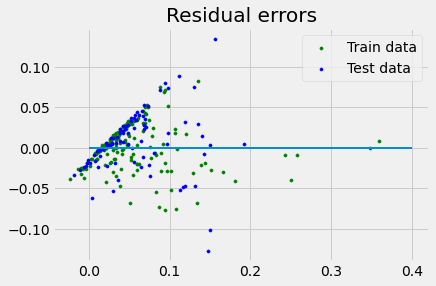

In [312]:
reg = linear_model.LinearRegression()

reg.fit(x_train, y_train)

# regression coefficients
print('Coefficients: ', reg.coef_)
  
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(x_test, y_test)))

preds = reg.predict(x_test)
errs = abs(preds - np.array(y_test).ravel())
print('Mean Absolute Error:', round(np.mean(errs), 2))
  
    
# plot for residual error
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(reg.predict(x_train), reg.predict(x_train) - y_train,
            color = "green", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(reg.predict(x_test), reg.predict(x_test) - y_test,
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 0.4, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()




Variance score: 0.512077507522865
Mean Absolute Error: 0.02


Text(0, 0.5, 'Error')

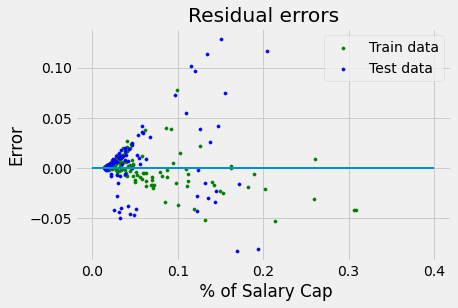

In [327]:
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(x_train, np.array(y_train).ravel())

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(rf.score(x_test, y_test)))

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)# Calculate the absolute errors
errors = abs(predictions - np.array(y_test).ravel())# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

## plotting residual errors in training data
plt.scatter(rf.predict(x_train), rf.predict(x_train) - np.array(y_train).ravel(),
            color = "green", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(rf.predict(x_test), rf.predict(x_test) - np.array(y_test).ravel(),
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 0.4, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
plt.xlabel(" % of Salary Cap")
plt.ylabel("Error")

In [317]:
'''   USING THE TRAINED MODELS TO PREDICT 2022   '''

# linear regression
preds22lr = reg.predict(x22)

test22lr = x22.copy()
test22lr['predlr'] = preds22lr

for p in test22lr.itertuples():
    fa22_stats_df.loc[p.Index, 'predlr'] = p.predlr

    
# random forest
preds22rf = rf.predict(x22)

test22rf = x22.copy()
test22rf['predrf'] = preds22rf

for p in test22rf.itertuples():
    fa22_stats_df.loc[p.Index, 'predrf'] = p.predrf

C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\923283028.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa22_stats_df.loc[p.Index, 'predlr'] = p.predlr
C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\923283028.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa22_stats_df.loc[p.Index, 'predrf'] = p.predrf


In [325]:
# calculating actual salary
fa22_stats_df['2022salary'] = round(fa22_stats_df['cap'] * fa22_stats_df['predrf'], 0)

#export
ANSWER = fa22_stats_df[['Player', '2022salary']].sort_values('2022salary', ascending=False).head(10).to_excel("JohnBrzezinski2022TopTen.xlsx", index=False)

# answer table
print("TOP TEN CONTRACTS FOR 2022 FREE AGENT CLASS")
fa22_stats_df[['Player', '2022salary']].sort_values('2022salary', ascending=False).head(10)

TOP TEN CONTRACTS FOR 2022 FREE AGENT CLASS


C:\Users\jrbrz\AppData\Local\Temp\ipykernel_2272\1717434857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa22_stats_df['2022salary'] = round(fa22_stats_df['cap'] * fa22_stats_df['predrf'], 0)


,Player,2022salary
1639,Bradley Beal,30681187.0
1922,Zach LaVine,28714448.0
1816,James Harden,26452831.0
1665,Miles Bridges,26094208.0
1620,Deandre Ayton,25029369.0
1678,Jalen Brunson,21162765.0
2096,Collin Sexton,20256128.0
1740,Luguentz Dort,19537183.0
2102,Anfernee Simons,18857771.0
2013,Jusuf Nurkic,14477541.0
